# Digits Classification with CNN

Useful link: https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html

`As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on all-convolutional networks); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.`

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 6)

from keras.datasets import fashion_mnist # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np

batch_size = 32 # in each iteration, we consider 32 training examples at once


drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons

Using TensorFlow backend.
/home/marat/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Let's fetch fashion-mnist data

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() # fetch CIFAR-10 data


Let's set some important variables

- num_train, num_test: number of training/test instances
- height, width, depth: Shape of images
- num_classes: number of output classes (there should be 10)

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:

num_train, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

print("Shape of images {}: ".format((height, width)))

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

Shape of images (28, 28): 


Let's show one of these images...

(28, 28)


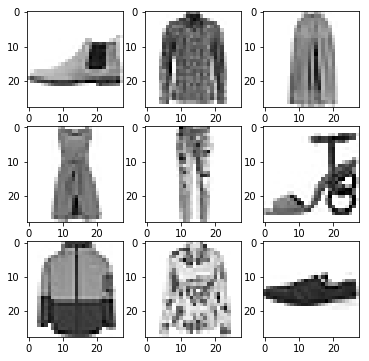

In [5]:
import matplotlib.pyplot as plt
print(X_train[12].shape)

base = 110

for i in range(1, 10):
    plt.subplot(3,3,i)
    plt.imshow(X_train[base+i], cmap=plt.cm.gray_r)

Add dummy dimension

In [6]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape

(60000, 28, 28, 1)

In [7]:
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

Let's make our first model. Just two convolutions, one maxpool, a flatten, and a softmax layer.

# Convolutional model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model = Sequential()

conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2
input_shape = (height, width, 1)
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
# First convolution. 32 filters, 3x3 filters
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), 
                        padding='same', activation='relu', input_shape=(height, width, 1)))

model.add(MaxPool2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

In [9]:
num_epochs = 1

model.fit(X_train, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) 

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 41s 759us/step - loss: 0.4675 - acc: 0.8367 - val_loss: 0.3695 - val_acc: 0.8670


In [10]:
model.evaluate(X_test, Y_test, verbose=1)

10000/10000 [==============================] - 2s 239us/step


[0.38471955237388611, 0.86719999999999997]


## Output of first convolutional layer

What does the output of the convolutional layer look like?

(28, 28, 1)

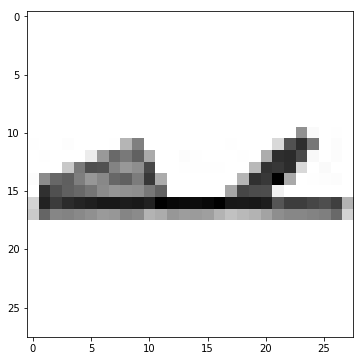

In [15]:
from keras import backend as K

def show_image(img):
    plt.imshow(np.squeeze(img), cmap=plt.cm.gray_r)

X = X_test[111]    
show_image(X)


X.shape

In [16]:
from keras import Model

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
intermediate_output = np.squeeze(intermediate_layer_model.predict(X[np.newaxis, ...]))

How does the first layer process our image?

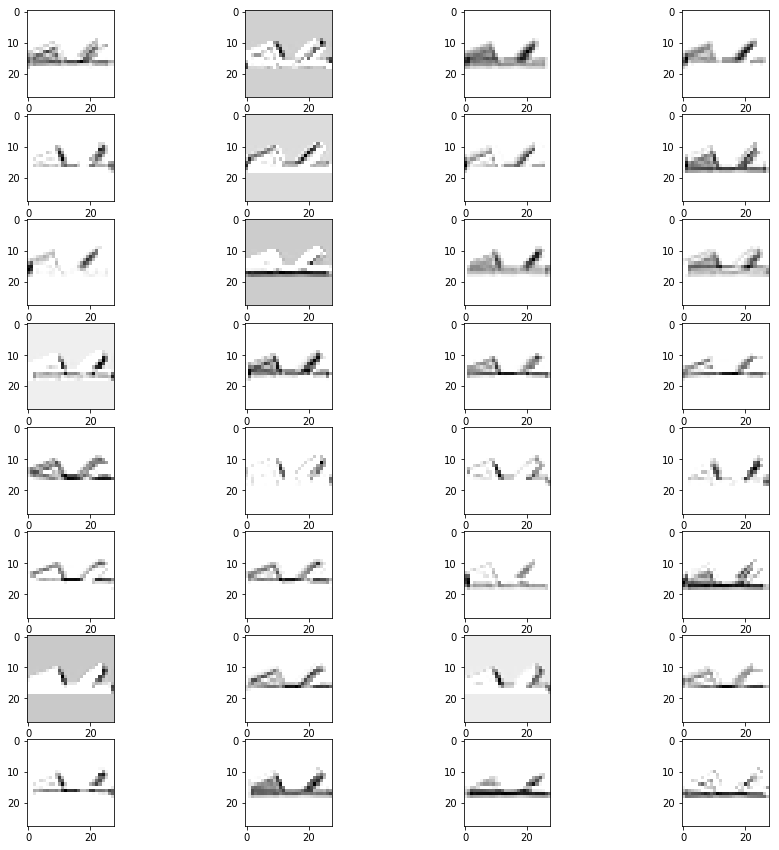

In [20]:
plt.rcParams['figure.figsize'] = (15, 15)

for i in range(conv_depth_1):
    plt.subplot(8, 4, i+1)
    plt.imshow(intermediate_output[:,:, i], cmap=plt.cm.gray_r);


(3, 3, 32)


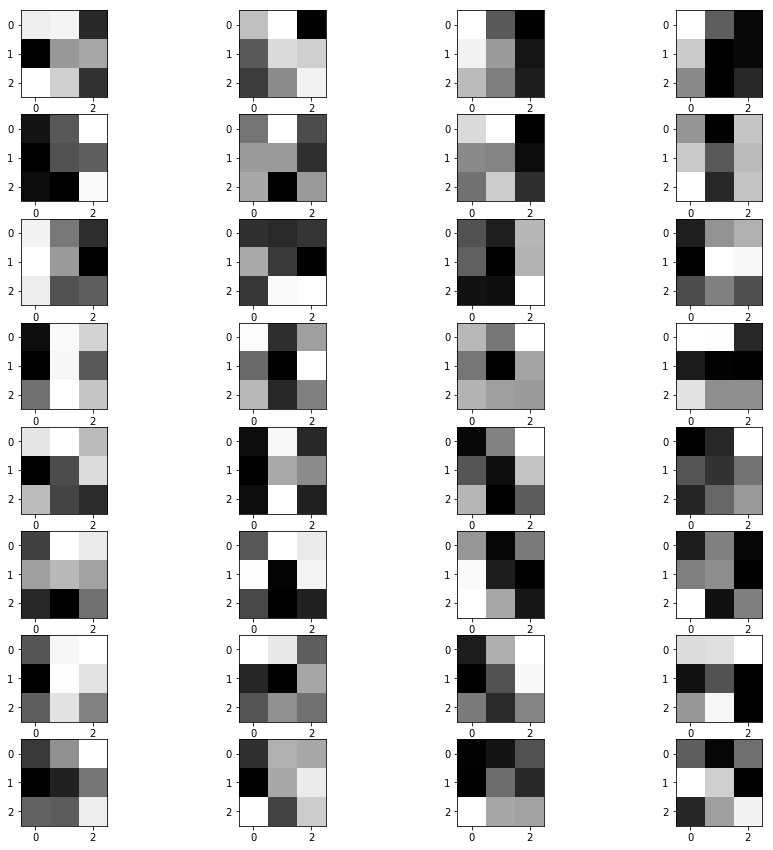

In [24]:
conv_layer = model.layers[0]


weights = np.squeeze(conv_layer.get_weights()[0])

print(weights.shape)
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(weights[:,:, i], cmap=plt.cm.gray_r)